# Compare Network Activations using Statistical Shape Analysis

## Import Necessary Packages

In [42]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import netrep
from netrep.metrics import LinearMetric
from netrep import conv_layers
import os, sys
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import segmentation_models as sm
import h5py as h5
import imgaug as ia
import imgaug.augmenters as iaa
sm.set_framework('tf.keras')

## Define Necessary Functions

In [2]:
def get_activation_model(model=None,layer_name=None):
    layer = None
    for l in model.layers:
        if l.name == layer_name:
            layer = l
    return tf.keras.Model(model.input, layer.output)

In [52]:
def get_activation_tensor(activation_model=None,stimulus=None,gray_scale=False, cremi=False):
    if type(stimulus) == str:
        with open(stimulus, "rb") as f:
            img = tf.image.decode_jpeg(f.read())
    else:
        img = stimulus
    if not gray_scale:
        if img.shape[-1]==1:
            img = tf.image.grayscale_to_rgb(img)
    else:
        if img.shape[-1]==3:
            img = tf.image.rgb_to_grayscale(img)
    if not cremi:
        img = tf.image.resize(img,(256,256))
    activation = activation_model(tf.expand_dims(img, axis=0))
    return activation

## Test Statistical Shape Analysis

### RESNET152

#### V1

##### ImageNet Activations

In [18]:
random_100_imgs = np.random.choice([file for file in os.listdir("imagenet-sample-images") if file.endswith(".JPEG")],size=100,replace=False)

In [19]:
imgnet_resnet = sm.Unet('resnet152',classes=1,encoder_weights='imagenet', activation='sigmoid')
cremi_resnet=keras.models.load_model("model_experiments/cremi_resnet152/model_weights/model_weights.ckpt")
layer_names = ['stage3_unit4_relu3','stage3_unit12_relu3','stage3_unit36_relu3']
imgnet_activations = []
cremi_activations = []
for layer in layer_names:
    imgnet_activation_model = get_activation_model(model=imgnet_resnet, layer_name=layer)
    cremi_activation_model = get_activation_model(model=cremi_resnet, layer_name = layer)
    imgnet_activations_layer = tf.stack([tf.squeeze(get_activation_tensor(imgnet_activation_model, os.path.join("imagenet-sample-images", img))) for img in random_100_imgs])
    print(imgnet_activations_layer.shape)
    cremi_activations_layer = tf.stack([tf.squeeze(get_activation_tensor(cremi_activation_model, os.path.join("imagenet-sample-images", img),gray_scale=True)) for img in random_100_imgs])
    print(cremi_activations_layer.shape)
    imgnet_activations.append(imgnet_activations_layer)
    cremi_activations.append(cremi_activations_layer)

(100, 16, 16, 256)
(100, 16, 16, 256)
(100, 16, 16, 256)
(100, 16, 16, 256)
(100, 16, 16, 256)
(100, 16, 16, 256)


In [49]:
sample_a = h5.File('../datasets/cremi/test/sample_A+_20160601.hdf')['volumes/raw'][:]
sample_b = h5.File('../datasets/cremi/test/sample_B+_20160601.hdf')['volumes/raw'][:]
sample_c = h5.File('../datasets/cremi/test/sample_C+_20160601.hdf')['volumes/raw'][:]
cremi = np.append(sample_a,sample_b,axis=0)
cremi = np.append(cremi,sample_b,axis=0)
cremi.shape
random_indices = np.random.choice(range(cremi.shape[0]),size=100,replace=False)
random_cremi=cremi[random_indices]
random_cremi = np.expand_dims(random_cremi,axis=-1)
crop = iaa.size.CropToFixedSize(256,256)
random_cremi = crop.augment_images(images=random_cremi)
random_cremi=tf.convert_to_tensor(random_cremi)
random_cremi.shape

TensorShape([100, 256, 256, 1])

In [53]:
imgnet_activations_cremi = []
cremi_activations_cremi = []
for layer in layer_names:
    imgnet_activation_model = get_activation_model(model=imgnet_resnet, layer_name=layer)
    cremi_activation_model = get_activation_model(model=cremi_resnet, layer_name = layer)
    imgnet_activations_layer = tf.stack([tf.squeeze(get_activation_tensor(imgnet_activation_model, random_cremi[i],cremi=True)) for i in range(random_cremi.shape[0])])
    print(imgnet_activations_layer.shape)
    cremi_activations_layer = tf.stack([tf.squeeze(get_activation_tensor(cremi_activation_model, random_cremi[i],gray_scale=True,cremi=True)) for i in range(random_cremi.shape[0])])
    print(cremi_activations_layer.shape)
    imgnet_activations_cremi.append(imgnet_activations_layer)
    cremi_activations_cremi.append(cremi_activations_layer)

(100, 16, 16, 256)
(100, 16, 16, 256)
(100, 16, 16, 256)
(100, 16, 16, 256)
(100, 16, 16, 256)
(100, 16, 16, 256)


In [61]:
imgnet_v_imgnet_min = []
imgnet_v_imgnet_mean = []
imgnet_v_imgnet_max = []
for imgnet_activation, cremi_activation in zip(imgnet_activations, cremi_activations):
    result = conv_layers.convolve_metric(LinearMetric(),imgnet_activation, cremi_activation)
    imgnet_v_imgnet_min.append(np.amin(result))
    imgnet_v_imgnet_mean.append(np.mean(result))
    imgnet_v_imgnet_max.append(np.amax(result))

100%|██████████| 256/256 [00:59<00:00,  4.28it/s]


In [62]:
cremi_v_cremi_min = []
cremi_v_cremi_mean = []
cremi_v_cremi_max = []
for imgnet_activation, cremi_activation in zip(imgnet_activations_cremi, cremi_activations_cremi):
    result = conv_layers.convolve_metric(LinearMetric(),imgnet_activation, cremi_activation)
    cremi_v_cremi_min.append(np.amin(result))
    cremi_v_cremi_mean.append(np.mean(result))
    cremi_v_cremi_max.append(np.amax(result))

100%|██████████| 256/256 [01:00<00:00,  4.25it/s]


In [63]:
imgnet_v_cremi_min = []
imgnet_v_cremi_mean = []
imgnet_v_cremi_max = []
for imgnet_activation, cremi_activation in zip(imgnet_activations, cremi_activations_cremi):
    result = conv_layers.convolve_metric(LinearMetric(),imgnet_activation, cremi_activation)
    imgnet_v_cremi_min.append(np.amin(result))
    imgnet_v_cremi_mean.append(np.mean(result))
    imgnet_v_cremi_max.append(np.amax(result))

100%|██████████| 256/256 [01:00<00:00,  4.22it/s]


In [64]:
cremi_v_imgnet_min = []
cremi_v_imgnet_mean = []
cremi_v_imgnet_max = []
for imgnet_activation, cremi_activation in zip(imgnet_activations_cremi, cremi_activations):
    result = conv_layers.convolve_metric(LinearMetric(),imgnet_activation, cremi_activation)
    cremi_v_imgnet_min.append(np.amin(result))
    cremi_v_imgnet_mean.append(np.mean(result))
    cremi_v_imgnet_max.append(np.amax(result))

100%|██████████| 256/256 [00:59<00:00,  4.27it/s]


In [65]:
print(imgnet_v_imgnet_min)
print(imgnet_v_imgnet_mean)
print(imgnet_v_imgnet_max)

[1.4048665968523775, 1.4550877327037057, 1.4467351054608388]
[1.479324295716234, 1.490385263602763, 1.4888547670726964]
[1.499920884649462, 1.504419669046841, 1.5055985424108387]


In [66]:
print(cremi_v_cremi_min)
print(cremi_v_cremi_mean)
print(cremi_v_cremi_max)

[1.4467754255903404, 1.4650655785783824, 1.4955244625549593]
[1.4783987895164827, 1.4803583424222366, 1.5008225549105694]
[1.4850814025999828, 1.4876234860216349, 1.5083764262637904]


In [68]:
print(imgnet_v_cremi_min)
print(imgnet_v_cremi_mean)
print(imgnet_v_cremi_max)

[1.4969806265608934, 1.5193557718276594, 1.5247325885679097]
[1.5049242537083458, 1.5218788034054684, 1.534120086371186]
[1.509175213045093, 1.5238451455176178, 1.5403589917138467]


In [69]:
print(cremi_v_imgnet_min)
print(cremi_v_imgnet_mean)
print(cremi_v_imgnet_max)

[1.4731419878541705, 1.4569082653352434, 1.4277181188909565]
[1.5074731277217222, 1.5020463586269783, 1.4911981036462159]
[1.5193214718756727, 1.5161352509229733, 1.5110305857247575]


In [70]:
layer_index = []
for layer in layer_names:
    i=0
    for model_layer in imgnet_resnet.layers:
        if layer == model_layer.name:
            layer_index.append(i)
        i+=1

Text(0.5, 0.98, 'Min Similarities of Resnet152 Activations to Natural and Unnatural Images Trained on ImageNet vs CREMI')

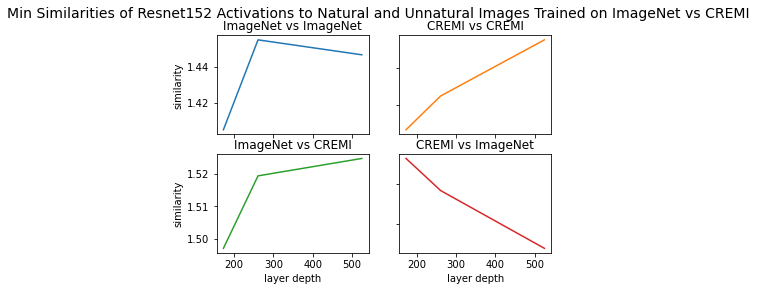

In [76]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(layer_index, imgnet_v_imgnet_min)
axs[0, 0].set_title('ImageNet vs ImageNet')
axs[0, 1].plot(layer_index, cremi_v_cremi_min, 'tab:orange')
axs[0, 1].set_title('CREMI vs CREMI')
axs[1, 0].plot(layer_index, imgnet_v_cremi_min, 'tab:green')
axs[1, 0].set_title('ImageNet vs CREMI')
axs[1, 1].plot(layer_index, cremi_v_imgnet_min, 'tab:red')
axs[1, 1].set_title('CREMI vs ImageNet')

for ax in axs.flat:
    ax.set(xlabel='layer depth', ylabel='similarity')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.suptitle("Min Similarities of Resnet152 Activations to Natural and Unnatural Images Trained on ImageNet vs CREMI", fontsize=14)

Text(0.5, 0.98, 'Mean Similarities of Resnet152 Activations to Natural and Unnatural Images Trained on ImageNet vs CREMI')

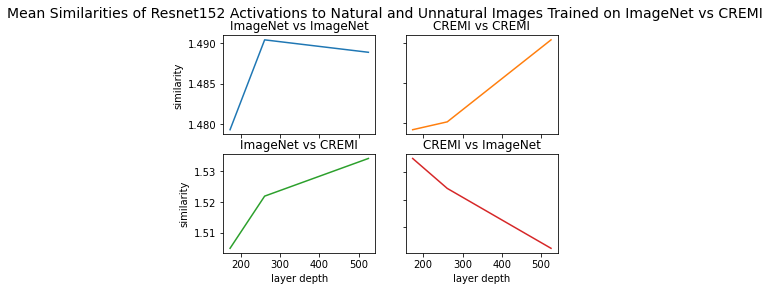

In [77]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(layer_index, imgnet_v_imgnet_mean)
axs[0, 0].set_title('ImageNet vs ImageNet')
axs[0, 1].plot(layer_index, cremi_v_cremi_mean, 'tab:orange')
axs[0, 1].set_title('CREMI vs CREMI')
axs[1, 0].plot(layer_index, imgnet_v_cremi_mean, 'tab:green')
axs[1, 0].set_title('ImageNet vs CREMI')
axs[1, 1].plot(layer_index, cremi_v_imgnet_mean, 'tab:red')
axs[1, 1].set_title('CREMI vs ImageNet')

for ax in axs.flat:
    ax.set(xlabel='layer depth', ylabel='similarity')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.suptitle("Mean Similarities of Resnet152 Activations to Natural and Unnatural Images Trained on ImageNet vs CREMI", fontsize=14)

Text(0.5, 0.98, 'Max Similarities of Resnet152 Activations to Natural and Unnatural Images Trained on ImageNet vs CREMI')

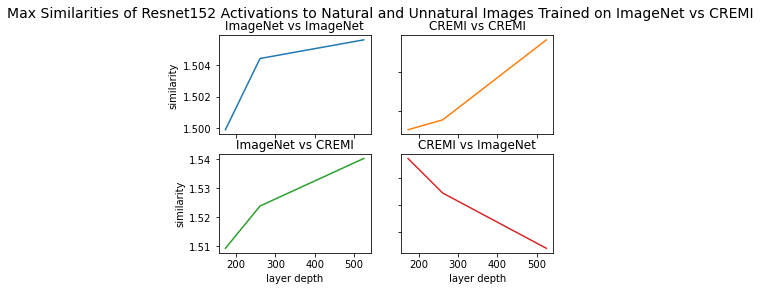

In [78]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(layer_index, imgnet_v_imgnet_max)
axs[0, 0].set_title('ImageNet vs ImageNet')
axs[0, 1].plot(layer_index, cremi_v_cremi_max, 'tab:orange')
axs[0, 1].set_title('CREMI vs CREMI')
axs[1, 0].plot(layer_index, imgnet_v_cremi_max, 'tab:green')
axs[1, 0].set_title('ImageNet vs CREMI')
axs[1, 1].plot(layer_index, cremi_v_imgnet_max, 'tab:red')
axs[1, 1].set_title('CREMI vs ImageNet')

for ax in axs.flat:
    ax.set(xlabel='layer depth', ylabel='similarity')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.suptitle("Max Similarities of Resnet152 Activations to Natural and Unnatural Images Trained on ImageNet vs CREMI", fontsize=14)

Text(0.5, 1.0, 'ResNet-152 Model depth vs Min Distance on 100 activations from ImageNet')

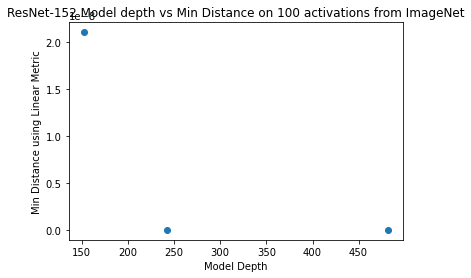

In [21]:
plt.scatter(layer_index,depth_vs_metrics_min)
plt.xlabel("Model Depth")
plt.ylabel("Min Distance using Linear Metric")
plt.title("ResNet-152 Model depth vs Min Distance on 100 activations from ImageNet")

Text(0.5, 1.0, 'ResNet-152 Model depth vs Average Distance on 100 activations from ImageNet')

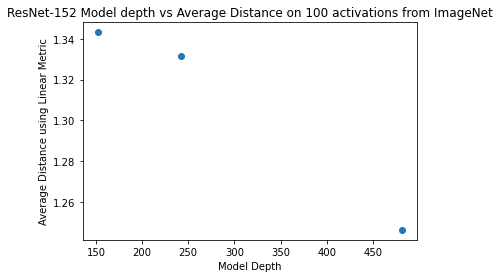

In [23]:
plt.scatter(layer_index,depth_vs_metric_avg)
plt.xlabel("Model Depth")
plt.ylabel("Average Distance using Linear Metric")
plt.title("ResNet-152 Model depth vs Average Distance on 100 activations from ImageNet")

Text(0.5, 1.0, 'ResNet-152 Model depth vs Max Distance on 100 activations from ImageNet')

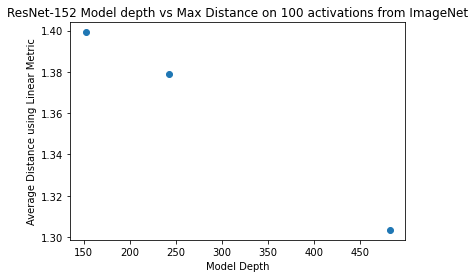

In [ ]:
plt.scatter(layer_index,depth_vs_metric_max)
plt.xlabel("Model Depth")
plt.ylabel("Average Distance using Linear Metric")
plt.title("ResNet-152 Model depth vs Max Distance on 100 activations from ImageNet")

##### Untrained Activation

In [7]:
untrained_resnet152 = tf.keras.applications.resnet.ResNet152(include_top=False, weights=None)
untrained_activation_model = get_activation_model(model=untrained_resnet152,layer_name="conv4_block4_out")
untrained_activations = []
for file in os.listdir("imagenet-sample-images"):
    if file.endswith(".JPEG"):
        img = os.path.join("imagenet-sample-images", file)
        try:
            activation = tf.squeeze(get_activation_tensor(activation_model=untrained_activation_model,stimuli_path=img))
            untrained_activations.append(activation)
        except ValueError:
            print(f'shape doesnt match for {img}')
untrained_activation = tf.stack(untrained_activations)
untrained_activation.shape

TensorShape([1000, 16, 16, 1024])

##### Linear Metric Comparison

In [10]:
try:
    linear_result = conv_layers.convolve_metric(linear_metric, trained_activation, untrained_activation)
except:
    print("linear metric doesn't work")

100%|██████████| 256/256 [34:20<00:00,  8.05s/it]


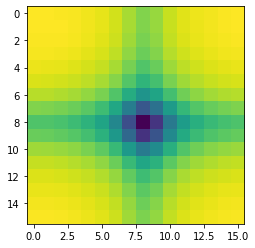

In [11]:
plt.imshow(linear_result)

In [12]:
print(f'Minimum Value for Linear Metric: {np.min(linear_result)}')
print(f'Average Value for Linear Metric: {np.mean(linear_result)}')
print(f'Maximum Value for Linear Metric: {np.max(linear_result)}')

Minimum Value for Linear Metric: 1.1924659133491418
Average Value for Linear Metric: 1.4506568810640117
Maximum Value for Linear Metric: 1.5024979223317558


##### Permutation Metric

In [13]:
from netrep.metrics import PermutationMetric
perm_metric = PermutationMetric()

In [ ]:
perm_result = conv_layers.convolve_metric(perm_metric,trained_activation, untrained_activation)

  4%|▍         | 11/256 [02:15<50:25, 12.35s/it]

In [ ]:
plt.imshow(perm_result)

In [ ]:
print(f'Minimum Value for Permuation Metric: {np.min(perm_result)}')
print(f'Average Value for Permutation Metric: {np.mean(perm_result)}')
print(f'Maximum Value for Permuation Metric: {np.max(perm_result)}')